In [4]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [27]:
di.display_html('''<h3>Confusion matrix for RM surveys conducted in year 2014 onwards. </h3>''', raw=True)

Confusion matrix for RM surveys conducted in year 2014 onwards.

In [31]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import csv
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, classification_report, \
    precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, HTML
import pandas as pd

%matplotlib inline



def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.matshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #target_names = target_names
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    for i, cas in enumerate(cm):
        for j, c in enumerate(cas):
            plt.text(j-.2, i+.2, "%.2f" % c, fontsize=8)

    #plt.savefig("confusion.png")
    plt.show()

def plot_precision_recall(precision, recall, thresholds, title):
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()


def get_df():
    with open('2014predictions.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        rows = list(row for row in reader)
        
        return pd.DataFrame(rows), rows
        
dataframe, rows = get_df()
    
y_true = []
y_pred = []
y_yes_no = []
y_scores = []

def get_label_number(label, classes):
    for the_class in classes:
        if the_class in label:
            return classes.index(the_class)    

groups = ["HARD CORAL", "SOFT CORAL", "ABIOTIC", "ALGAE", "SPONGE", "SEAGRASS", "OTHER", "INDETERMINATE"]
groups_orig = ["HC", "SC", "AB", "A", "SP", "SG", "OT", "IN"]


target_names = groups
chart_labels = groups
label_numbers = [index for index, item in enumerate(chart_labels)]

for row in rows:
    
    original = groups_orig.index(row["GROUP_CODE"])
    prediction = groups.index(row["PREDICTION"])
    predition_score = row["PREDICTION_SCORE"]
    
    y_true.append(original)
    y_pred.append(prediction)
    y_scores.append(float(predition_score))



def plot_dynamic_confusion(prediction_score_threshold=0.9):
        new_y_true = []
        new_y_pred = []
        new_y_scores = []
        
        for index, item in enumerate(y_scores):
            if item >= prediction_score_threshold:
                new_y_true.append(y_true[index])
                new_y_pred.append(y_pred[index])
                new_y_scores.append(y_scores[index])
        
        cm = confusion_matrix(new_y_true, new_y_pred, label_numbers)
        np.set_printoptions(precision=2)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plot_confusion_matrix(cm_normalized, chart_labels)
        
        return "Coverage: " + str( 100 - ((len(y_scores) - len(new_y_scores)) / float(len(y_scores)) * 100.0) ) + "%, " + "Prediction score threshold: 0.9" 

#interact(plot_dynamic_confusion, prediction_score_threshold=(0.00, 1.00, 0.001))

In [28]:
di.display_html('''<h3>Reef breakdown on accuracies for particluar codes - machine compared to human validation data. </h3>''', raw=True)

Reef breakdown on accuracies for particluar codes - machine compared to human validation data.

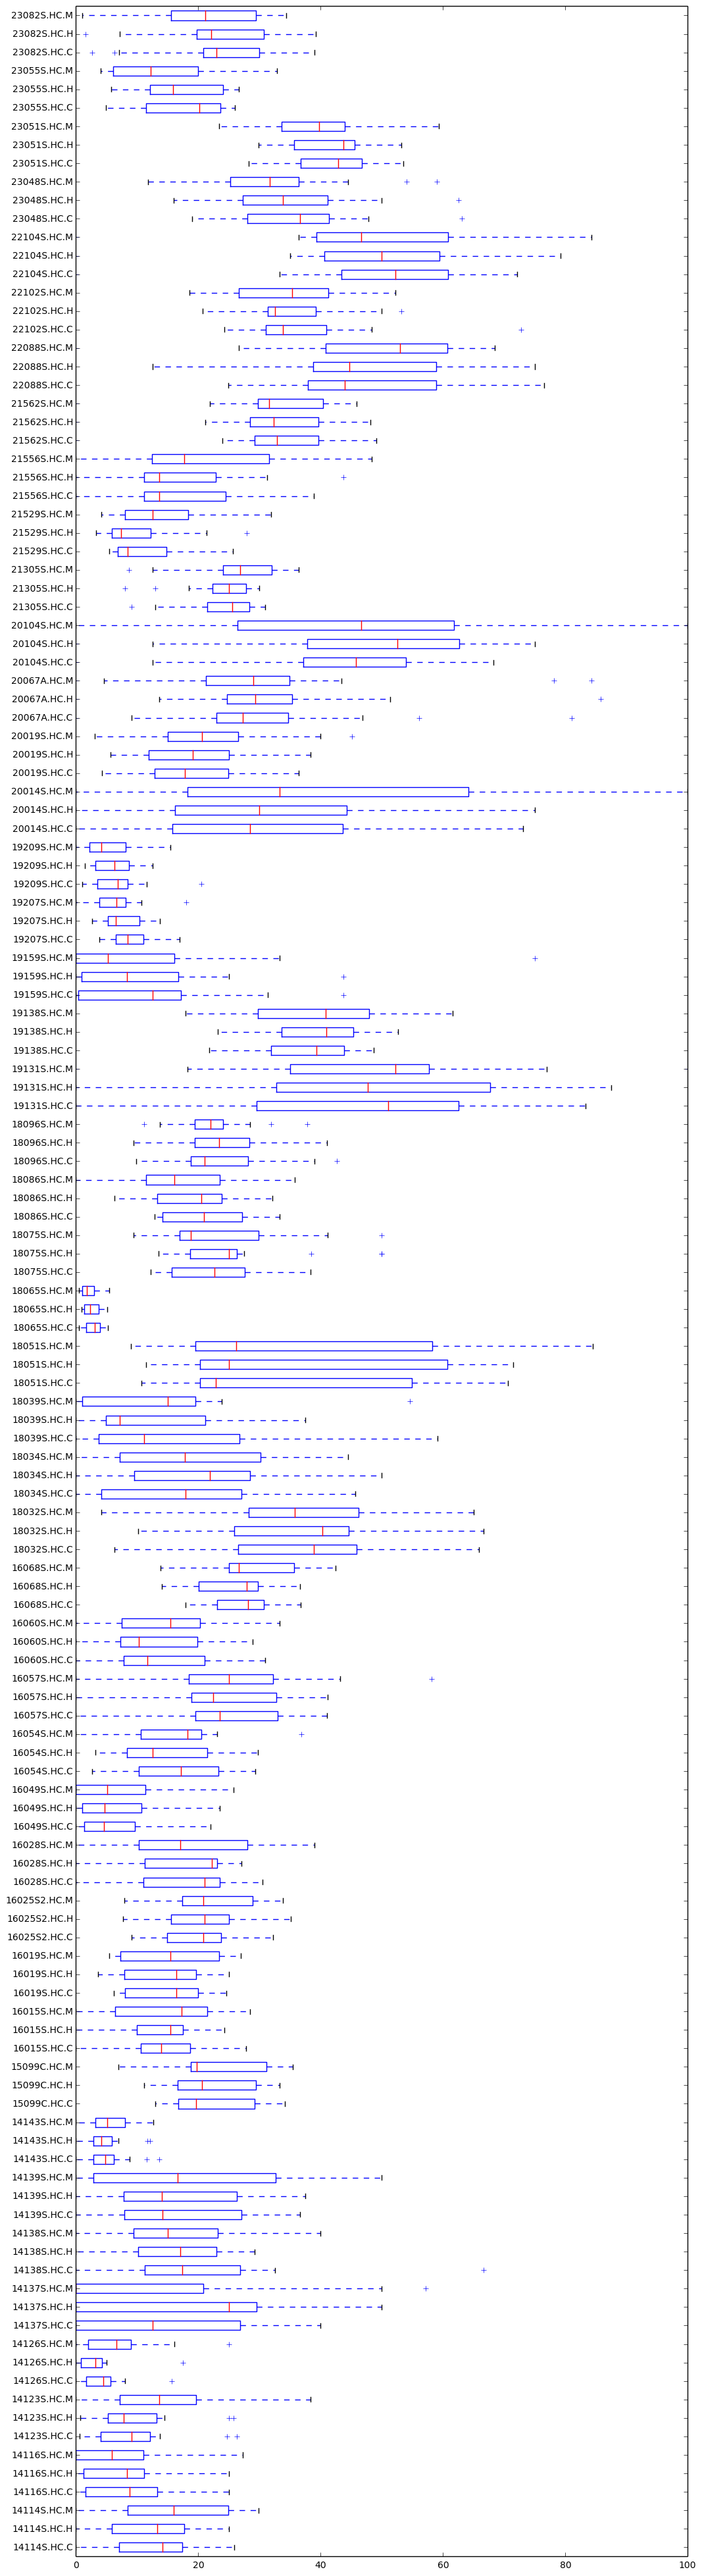

In [30]:
#di.display_html('''<h3>Box plots per reef, for percentage cover of codes of Human (H), Machine (M), Combined humand and machine (C) </h3>''', raw=True)
#di.display_html('''<p>SP.M.HAVANNAH REEF means: Sponge, Machine labelled, for HAVANNAH REEF </p>''', raw=True)
#di.display_html('''<p>SP.C.HAVANNAH REEF means: Sponge, Combined machine and human, for HAVANNAH REEF. Where combined is using the human labelled points, for points which could not be labelled accuractely by the machine. About 60% machine, 40% human.</p>''', raw=True)

def tally_transect_coverages(dataframe, prediction_score_threshold=0.9):
    #df = dataframe.sample(frac=0.1)
    #dataframe, rows = get_df()
    sites = dataframe['SITE_NO'].unique()
    transects = dataframe['TRANSECT_NO'].unique()
    reefs = dataframe['FULLREEF_ID'].unique()
    group_codes = dataframe['GROUP_CODE'].unique()
    prediction_codes = dataframe['PREDICTION'].unique()
    dataframe['PREDICTION_SCORE'] = dataframe['PREDICTION_SCORE'].astype('float64')
    
    #for pred_code in prediction_codes:
    #    print(pred_code)
    #    dataframe.ix[dataframe["PREDICTION"] == pred_code, 'PREDICTION'] = groups_orig[groups.index(pred_code)]
    
    printable = []
    tallys = {}
    for reef in reefs:
        reef_tallys = {}
        
        for site in sites:
            for transect in transects:
                
                if "2 shallow" in site: # and reef != "HAVANNAH REEF":
                    continue
                    
                total_df = dataframe.loc[(dataframe['FULLREEF_ID'] == reef) & (dataframe['SITE_NO'] == site) & (dataframe['TRANSECT_NO'] == transect)]
                total = float(len(total_df))

                predicted_total_df = dataframe.loc[(dataframe['FULLREEF_ID'] == reef) & (dataframe['PREDICTION_SCORE'] >= prediction_score_threshold) & (dataframe['SITE_NO'] == site) & (dataframe['TRANSECT_NO'] == transect)]
                predicted_total = float(len((predicted_total_df)))

                diff_df = dataframe.loc[(dataframe['FULLREEF_ID'] == reef) & (dataframe['PREDICTION_SCORE'] < prediction_score_threshold) & (dataframe['SITE_NO'] == site) & (dataframe['TRANSECT_NO'] == transect)]
                diff_total = float(len((diff_df)))
                                
                
                for code in group_codes:
                    
                    if code != "HC":
                        continue
                    
                    prediction_code = groups[groups_orig.index(code)]
                    diff_code_total = float(len(diff_df.loc[(diff_df['FULLREEF_ID'] == reef) & (diff_df['GROUP_CODE'] == code) & (diff_df['SITE_NO'] == site) & (diff_df['TRANSECT_NO'] == transect)]))
                    code_total = float(len(dataframe.loc[(dataframe['FULLREEF_ID'] == reef) & (dataframe['GROUP_CODE'] == code) & (dataframe['SITE_NO'] == site) & (dataframe['TRANSECT_NO'] == transect)]))
                    predicted_code_total = float(len(dataframe.loc[(dataframe['FULLREEF_ID'] == reef) & (dataframe['PREDICTION'] == prediction_code) & (dataframe['SITE_NO'] == site) & (dataframe['TRANSECT_NO'] == transect) & (dataframe['PREDICTION_SCORE'] >= prediction_score_threshold)]))
                    #print(reef + ": " + site + ": " + transect + ": " + code + ": " + str(code_total/total*100) + ", " + str(predicted_code_total/predicted_total*100))

                    manual_percentage = code_total/total*100 if total != 0 else 0
                    percentage = predicted_code_total/predicted_total*100 if predicted_total != 0 else 0
                    diff_percentage = diff_code_total/diff_total*100 if diff_total != 0 else 0
                    combined_percentage = (diff_percentage + percentage) / 2.0
                    
                    reef_tallys = tallys.get(code, {})
                    
                    #tally = reef_tallys.get(code+".H."+reef, [])
                    tally = reef_tallys.get(reef+"."+code+".H", [])
                    tally.append(manual_percentage)
                    #reef_tallys[code+".H."+reef] = tally
                    reef_tallys[reef+"."+code+".H"] = tally

                    #tally = reef_tallys.get(code+".C."+reef, [])
                    tally = reef_tallys.get(reef+"."+code+".C", [])
                    tally.append(combined_percentage)
                    #reef_tallys[code+".C."+reef] = tally
                    reef_tallys[reef+"."+code+".C"] = tally

                    #tally = reef_tallys.get(code+".M."+reef, [])
                    tally = reef_tallys.get(reef+"."+code+".M", [])
                    tally.append(percentage)
                    #reef_tallys[code+".M."+reef] = tally
                    reef_tallys[reef+"."+code+".M"] = tally
                    
                    tallys[code] = reef_tallys
        
    for key in tallys:    
        df = pd.DataFrame(tallys[key])
        df.plot.box(vert=False)
        


    #return "Prediction score threshold: 0.9"
    #for key in tallys:
        #print(len(tallys[key]), tallys[key])
        #print(key, len(tallys[key]))
        
    return tallys

plt.rcParams["figure.figsize"] = (12, 50,)

#print("here")
result_df = pd.DataFrame(tally_transect_coverages(dataframe))
#print(result_df)
#result_df.plot.box(vert=False)